In [38]:
import sqlite3 as sql
import plotly.express as px
from collections import Counter

## Accès à la base de données

* Ouvrir et intérroger une base de données SQLite: https://docs.python.org/3/library/sqlite3.html

In [2]:
### Définir le chemin du fichier
db_file = '/home/francesco/shared_files/python_notebooks/astonomers/data/generic_database.sqlite'

In [23]:
### Créer une connexion vers la base de données
# Attention: si la base de données n'existe pas, elle est créée à l'endroit indiqué.
# Ce qui est une manière de la créer si souhaité
cn = sql.connect(db_file)
# Le contenu de la variable: connexion
cn

## Explorer la fréquence des occupations

In [10]:
### La requête à effectuer
# Préparée généralement directement sur la BD SQLite
# Elle produit la distribution des métiers mentionnes,
# c'est-à-dire l'effectif de chaque modalité de la variable
q1 = """
SELECT label_occupation, COUNT(*) AS freq
FROM v_pursuits vp
GROUP BY label_occupation 
ORDER BY freq DESC;
"""

In [11]:
### Création du conteneur du résultat de la requête
cur = cn.cursor()
cur

In [12]:
### Exécuter la requête et récupérer le résultat
cur.execute(q1)
# La méthode 'fetchall' permet de récupérer toutes les lignes
r = cur.fetchall()

In [13]:
### Longueur, type du résultat et premières lignes du résultat
len(r), type(r), r[:3]

(95, list, [('Mathematics', 128), ('Astronomy', 102), ('Physics', 18)])

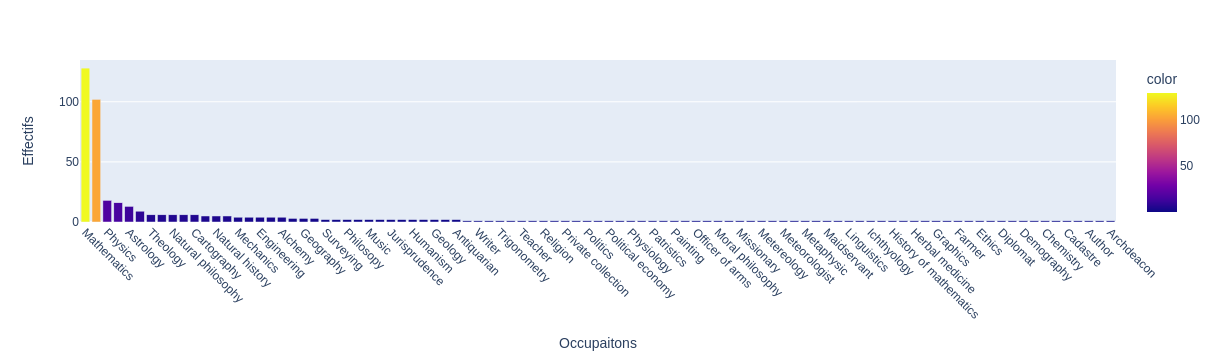

In [22]:
### Représentation graphique: graphique à barres
# https://plotly.com/python/bar-charts/

fig = px.bar(x=[i[0] for i in r], y=[i[1] for i in r], labels={'x':'Occupaitons','y':'Effectifs'}, color=[i[1] for i in r])

## Alternative avec filtre
#fig = px.bar(x=[i[0] for i in r if i[1] > 1 ], y=[i[1] for i in r  if i[1] > 1 ])

# Changer l'angle des x-labels
fig.update_xaxes(tickangle=45)
# Noter les fonctionnalités permettant d'interagir avec le graphique
fig.show()

## Explorer les cooccurrences d'occupations

* Une personne est considérée comme lien entre deux occupations
* On va donc créer des paires d'occupations, puis les compter et les représenter


In [76]:
### Requête qui créé les paires d'occupations
q2 = """
WITH tw1 AS (
SELECT *
FROM v_pursuits
ORDER BY label_occupation 
)
SELECT vp.label_occupation, vp2.label_occupation 
FROM tw1 vp, tw1 vp2 
WHERE vp.pk_person = vp2.pk_person 
AND vp2.pk_occupation  > vp.pk_occupation;
"""

In [77]:
### Création du conteneur du résultat de la requête
cur = cn.cursor()
cur

In [78]:
### Exécuter la requête et récupérer le résultat
cur.execute(q2)
# La méthode 'fetchall' permet de récupérer toutes les lignes
r = cur.fetchall()

In [79]:
### Longueur, type du résultat et premières lignes du résultat
len(r), type(r), r[:3]

(358,
 list,
 [('Soldier', 'Theology'), ('Occult', 'Physician'), ('Occult', 'Soldier')])

In [80]:
### Tester s'il y a des paires pour lesquelles le premier terme est après le deuxième
#  dans l'ordre alphabétique
to_reverse_eff = 0
to_reverse_l = []
for i in r:
    if i[0] > i[1]:
        to_reverse_eff += 1
        to_reverse_l.append(i)
to_reverse_eff, to_reverse_l[:3]

(29,
 [('Mathematics', 'Geometry'),
  ('Mathematics', 'Geometry'),
  ('Mathematics', 'Engineering')])

In [85]:
### Mettre toutes le spaires en ordre alphabétique et transformer en chaînes de caractères
standardized_l = []
for i in r:
    if i[0] > i[1]:
        standardized_l.append(f"{i[1]}_{i[0]}")
    else:
        standardized_l.append(f"{i[0]}_{i[1]}")
standardized_l[:5]

['Soldier_Theology',
 'Occult_Physician',
 'Occult_Soldier',
 'Occult_Theology',
 'Physician_Soldier']

In [88]:
### Trier la liste
standardized_l.sort()
standardized_l[:5]

['Alchemy_Antiquarian',
 'Alchemy_Astrology',
 'Alchemy_Astrology',
 'Alchemy_Astrology',
 'Alchemy_Astronomy']

In [90]:
### Compter le nombre d'occurrences pour chaque paire
ctr = Counter(standardized_l)
list(ctr.items())[:7]

[('Alchemy_Antiquarian', 1),
 ('Alchemy_Astrology', 3),
 ('Alchemy_Astronomy', 1),
 ('Alchemy_Hermeticism', 1),
 ('Alchemy_Mathematics', 1),
 ('Alchemy_Natural philosophy', 1),
 ('Alchemy_Navigation', 1)]

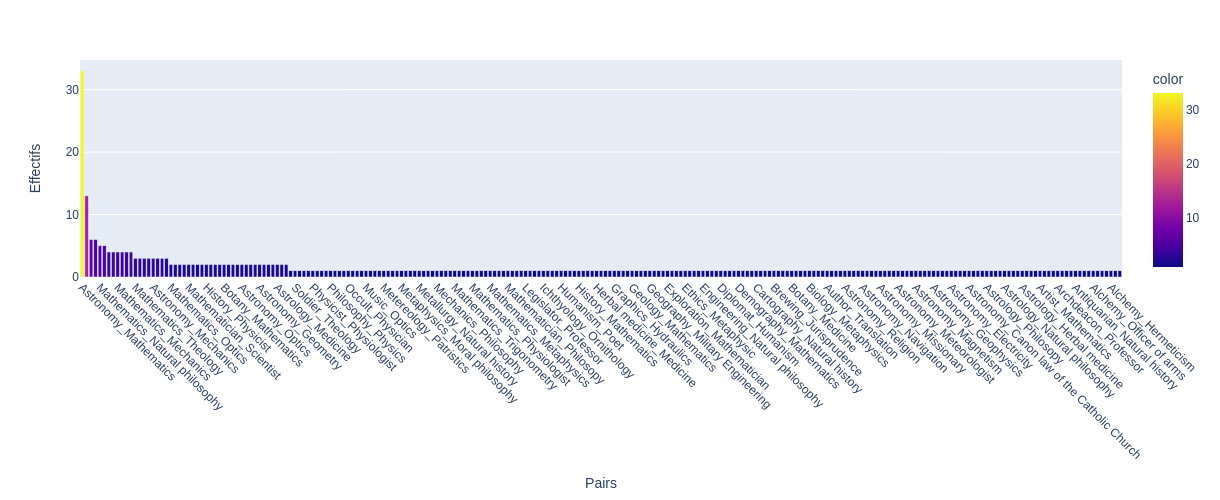

In [91]:
### Représentation graphique: graphique à barres.
#  Noter le tri par effectif, introduit directement dans les paramètres du graphes
# https://plotly.com/python/bar-charts/

fig = px.bar(x=ctr.keys(), y=ctr.values(), height=500, labels={'x':'Pairs','y':'Effectifs'}, color = ctr.values()) 

# Changer l'angle des x-labels
fig.update_xaxes(tickangle=45)
fig.update_layout( xaxis={'categoryorder':'total descending'})
# Noter les fonctionnalités permettant d'interagir avec le graphique
fig.show()